# Landfall rainfall

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [19]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import math
import matplotlib.cm as cm
from src.datasources import codab, imerg
from src.constants import *
from src import db_utils

## Load data

### Landfall dates

In [3]:
load_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "landfall_time_location_fixed_adm1_v7.csv"
)
landfall_df = pd.read_csv(load_path)

In [4]:
# keeping only USA_WIND as this is the most complete wind record
cols = [
    "SID",
    "SEASON",
    "NAME",
    "USA_WIND",
    "LAT",
    "LON",
    "year",
    "month",
    "day",
]

landfall_df = landfall_df[cols]

date_cols = ["year", "month", "day"]
landfall_df[date_cols] = landfall_df[date_cols].astype(int)
landfall_df["landfall_date"] = pd.to_datetime(
    landfall_df[["year", "month", "day"]]
)

# correct single negative USA_WIND
landfall_df["USA_WIND"] = landfall_df["USA_WIND"].abs()

In [5]:
landfall_df

,SID,SEASON,NAME,USA_WIND,LAT,LON,year,month,day,landfall_date
0,1999357S08076,2000,ASTRIDE,25.000000,-13.633333,40.466667,2000,1,3,2000-01-03
1,2000032S11116,2000,ELINE:LEONE,109.000000,-20.550000,34.750000,2000,2,22,2000-02-22
2,2000058S14063,2000,GLORIA,25.000000,-23.983333,35.433333,2000,3,9,2000-03-09
3,2000083S17102,2000,HUDAH,80.000000,-17.200000,38.300000,2000,4,8,2000-04-08
4,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26
5,2003056S21042,2003,JAPHET,86.500000,-21.800000,35.250000,2003,3,2,2003-03-02
6,2007043S11071,2007,FAVIO,93.333333,-21.900000,35.300000,2007,2,22,2007-02-22
7,2008062S10064,2008,JOKWE,94.166667,-15.983333,40.133333,2008,3,8,2008-03-08
8,2009082S16039,2009,IZILDA,15.000000,-20.200000,34.700000,2009,3,29,2009-03-29
9,2012010S24049,2012,DANDO,NaN,-24.800000,34.500000,2012,1,16,2012-01-16


### CODAB

In [6]:
adm1 = codab.load_codab(aoi_only=True)

<Axes: >

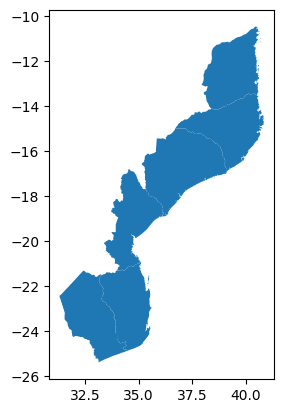

In [7]:
adm1.plot()

In [8]:
aoi_adm1_pcodes = adm1["ADM1_PCODE"].unique()

### IMERG

In [9]:
IMERG_START_DATE = pd.to_datetime("2000-06-01")
extra_days = 1
dfs = []
for sid, row in landfall_df.set_index("SID").iterrows():
    landfall_date = row["landfall_date"]
    start_date = landfall_date - pd.Timedelta(days=extra_days)
    end_date = landfall_date + pd.Timedelta(days=extra_days)
    if end_date < IMERG_START_DATE:
        print(f"{row['NAME']} too early")
        continue
    df_in = imerg.fetch_imerg_data(aoi_adm1_pcodes, start_date, end_date)
    df_in["SID"] = sid
    dfs.append(df_in)

ASTRIDE too early
ELINE:LEONE too early
GLORIA too early
HUDAH too early


In [10]:
imerg_df = pd.concat(dfs, ignore_index=True)

In [11]:
imerg_df

,iso3,pcode,valid_date,adm_level,mean,median,min,max,count,sum,std,SID
0,MOZ,MZ01,2002-10-25,1,0.006358,0.000000,0.0,2.175000,2567,16.320000,0.088569,2002364S16045
1,MOZ,MZ01,2002-10-26,1,0.004842,0.000000,0.0,0.470000,2567,12.429999,0.034060,2002364S16045
2,MOZ,MZ01,2002-10-27,1,0.004815,0.000000,0.0,1.235000,2567,12.360000,0.054999,2002364S16045
3,MOZ,MZ02,2002-10-25,1,0.006411,0.000000,0.0,0.465000,2636,16.900000,0.030037,2002364S16045
4,MOZ,MZ02,2002-10-26,1,0.003545,0.000000,0.0,0.260000,2636,9.345000,0.019942,2002364S16045
...,...,...,...,...,...,...,...,...,...,...,...,...
409,MOZ,MZ09,2024-03-12,1,24.026690,10.934999,0.0,199.310000,2317,55669.840000,30.353436,2024071S20039
410,MOZ,MZ09,2024-03-13,1,9.223557,1.570000,0.0,114.500000,2317,21370.979000,16.398250,2024071S20039
411,MOZ,MZ11,2024-03-11,1,6.263532,1.110000,0.0,113.134995,3460,21671.820000,12.329615,2024071S20039
412,MOZ,MZ11,2024-03-12,1,4.774464,1.932500,0.0,42.820000,3460,16519.645000,6.716722,2024071S20039


In [12]:
imerg_sum_df = imerg_df.groupby(["pcode", "SID"])["mean"].sum().reset_index()
imerg_sum_df = imerg_sum_df.rename(columns={"mean": "sum_mean_rain"})
imerg_sum_df

,pcode,SID,sum_mean_rain
0,MZ01,2002364S16045,0.016015
1,MZ01,2003056S21042,0.171965
2,MZ01,2007043S11071,12.483385
3,MZ01,2008062S10064,47.419393
4,MZ01,2009082S16039,16.721129
...,...,...,...
127,MZ11,2022020S13059,172.006284
128,MZ11,2022065S16055,113.405056
129,MZ11,2022110S12051,17.506361
130,MZ11,2023061S22036,191.066692


## Combine data

In [13]:
combined_df = landfall_df.merge(imerg_sum_df).merge(
    adm1.rename(columns={"ADM1_PCODE": "pcode"})[["pcode", "ADM1_PT"]]
)
combined_df["nameseason"] = (
    combined_df["NAME"].str.capitalize()
    + " "
    + combined_df["year"].astype(str)
)
combined_df

,SID,SEASON,NAME,USA_WIND,LAT,LON,year,month,day,landfall_date,pcode,sum_mean_rain,ADM1_PT,nameseason
0,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26,MZ01,0.016015,Cabo Delgado,Delfina 2002
1,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26,MZ02,0.020901,Gaza,Delfina 2002
2,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26,MZ03,0.072704,Inhambane,Delfina 2002
3,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26,MZ07,5.913417,Nampula,Delfina 2002
4,2002364S16045,2003,DELFINA,52.500000,-15.983333,40.066667,2002,10,26,2002-10-26,MZ09,6.525196,Sofala,Delfina 2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2024071S20039,2024,FILIPO,51.666667,-21.333333,35.033333,2024,3,12,2024-03-12,MZ02,64.519950,Gaza,Filipo 2024
134,2024071S20039,2024,FILIPO,51.666667,-21.333333,35.033333,2024,3,12,2024-03-12,MZ03,96.246190,Inhambane,Filipo 2024
135,2024071S20039,2024,FILIPO,51.666667,-21.333333,35.033333,2024,3,12,2024-03-12,MZ07,6.874249,Nampula,Filipo 2024
136,2024071S20039,2024,FILIPO,51.666667,-21.333333,35.033333,2024,3,12,2024-03-12,MZ09,64.193284,Sofala,Filipo 2024


## Plot

In [14]:
def calculate_rp(group, col_name, total_seasons):
    group["rank"] = group[col_name].rank(ascending=False)
    group["rp"] = (total_seasons + 1) / group["rank"]
    return group

In [15]:
# seasons for RP calc is total seasons minus current season
total_seasons = combined_df["SEASON"].nunique() - 1

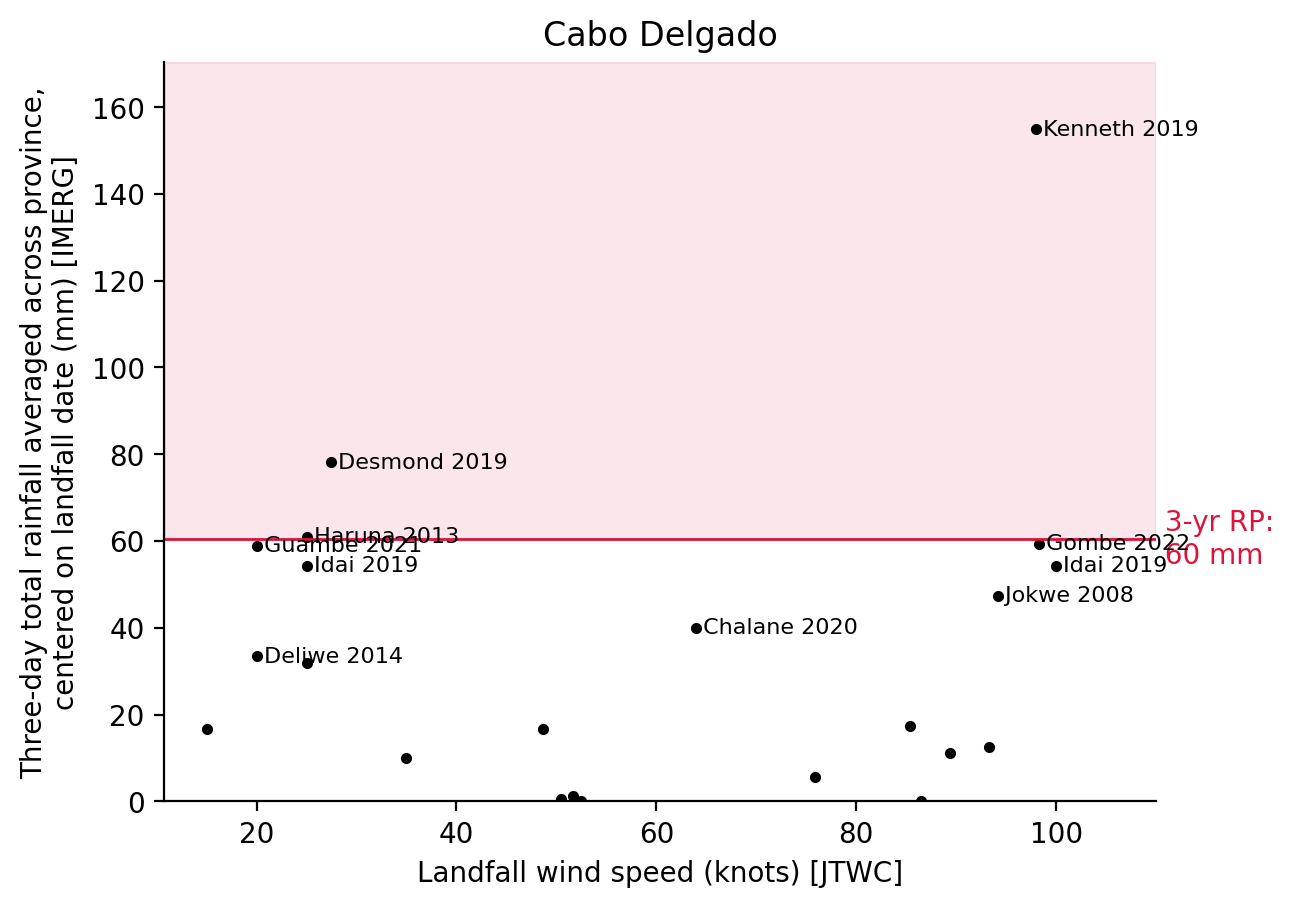

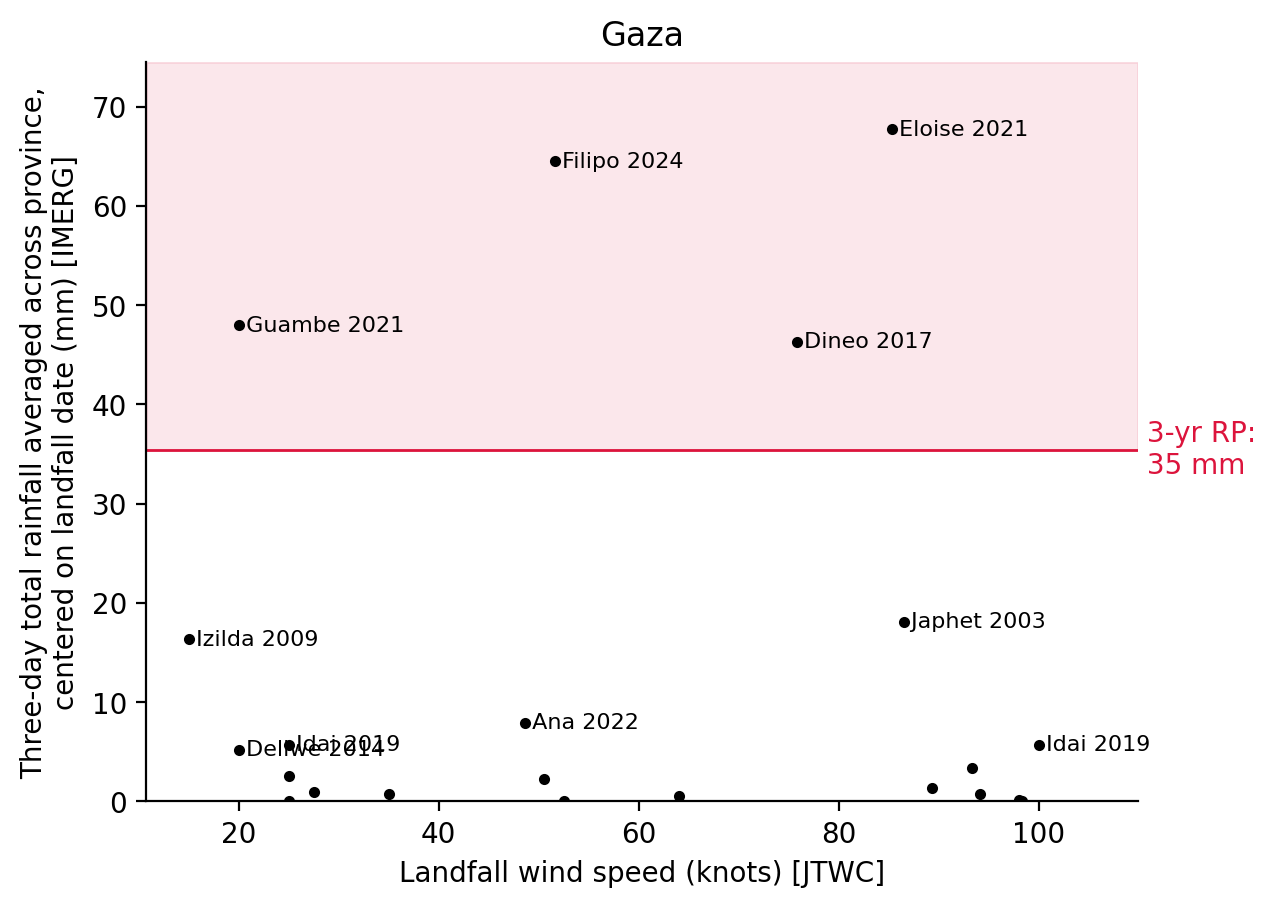

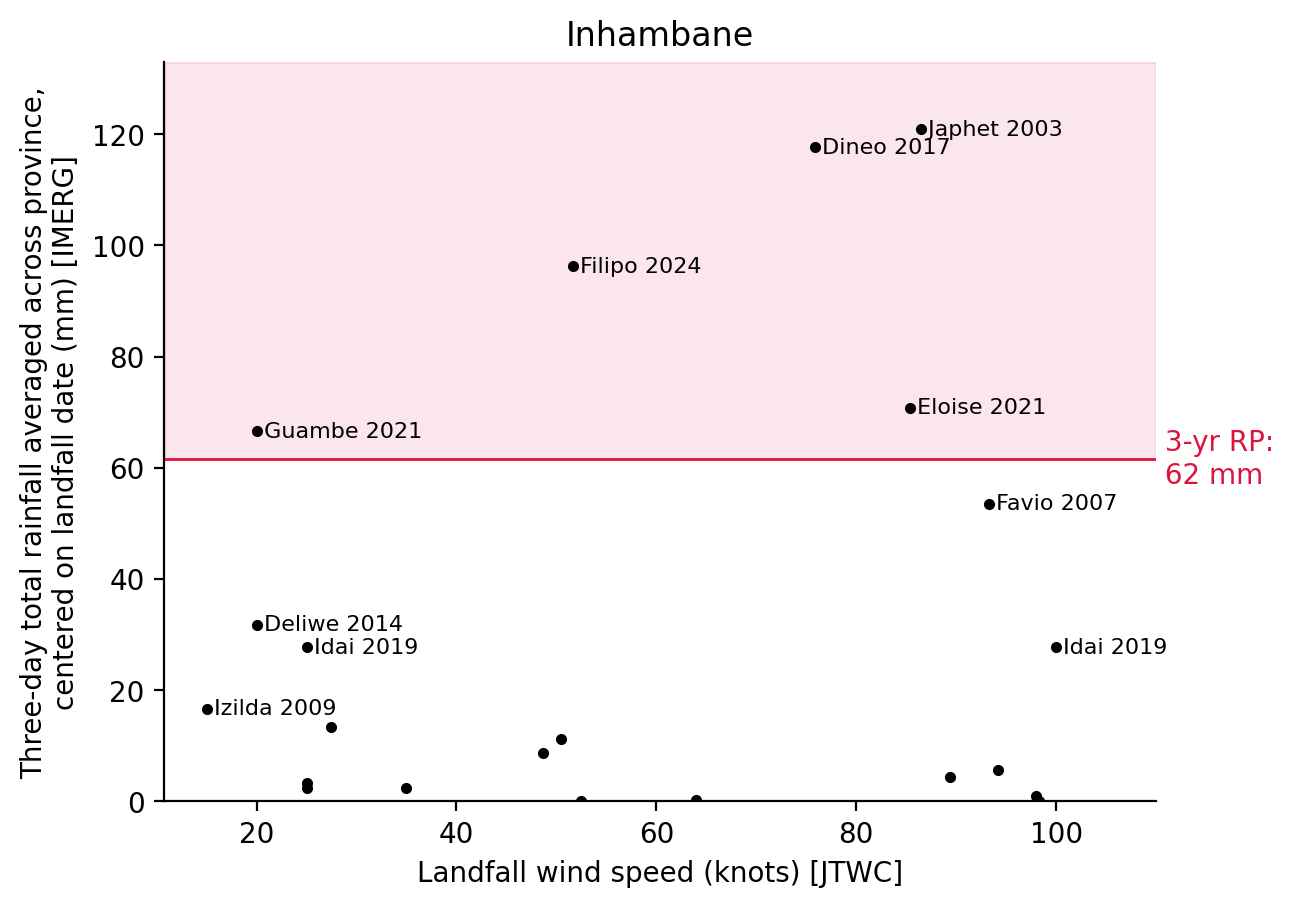

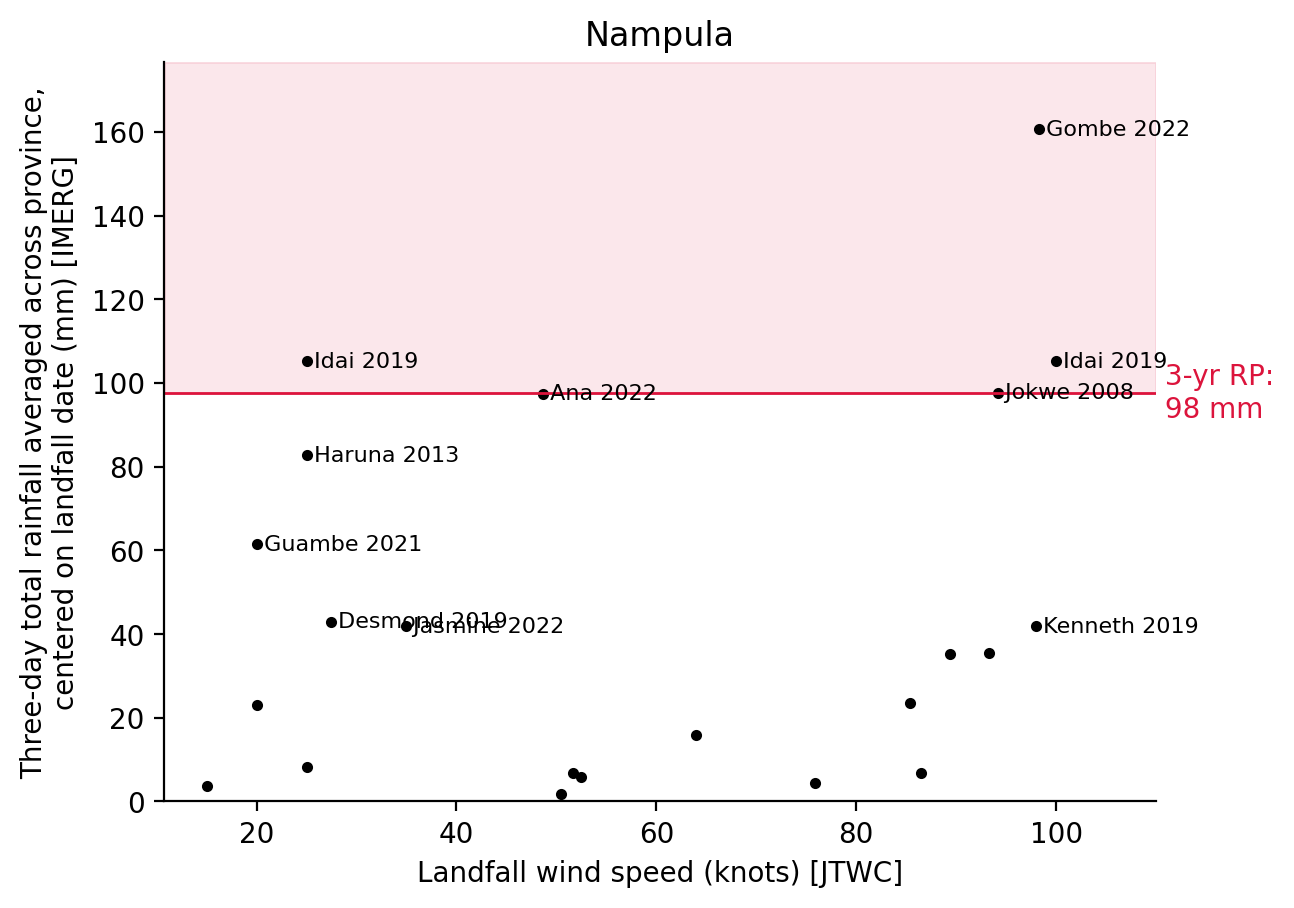

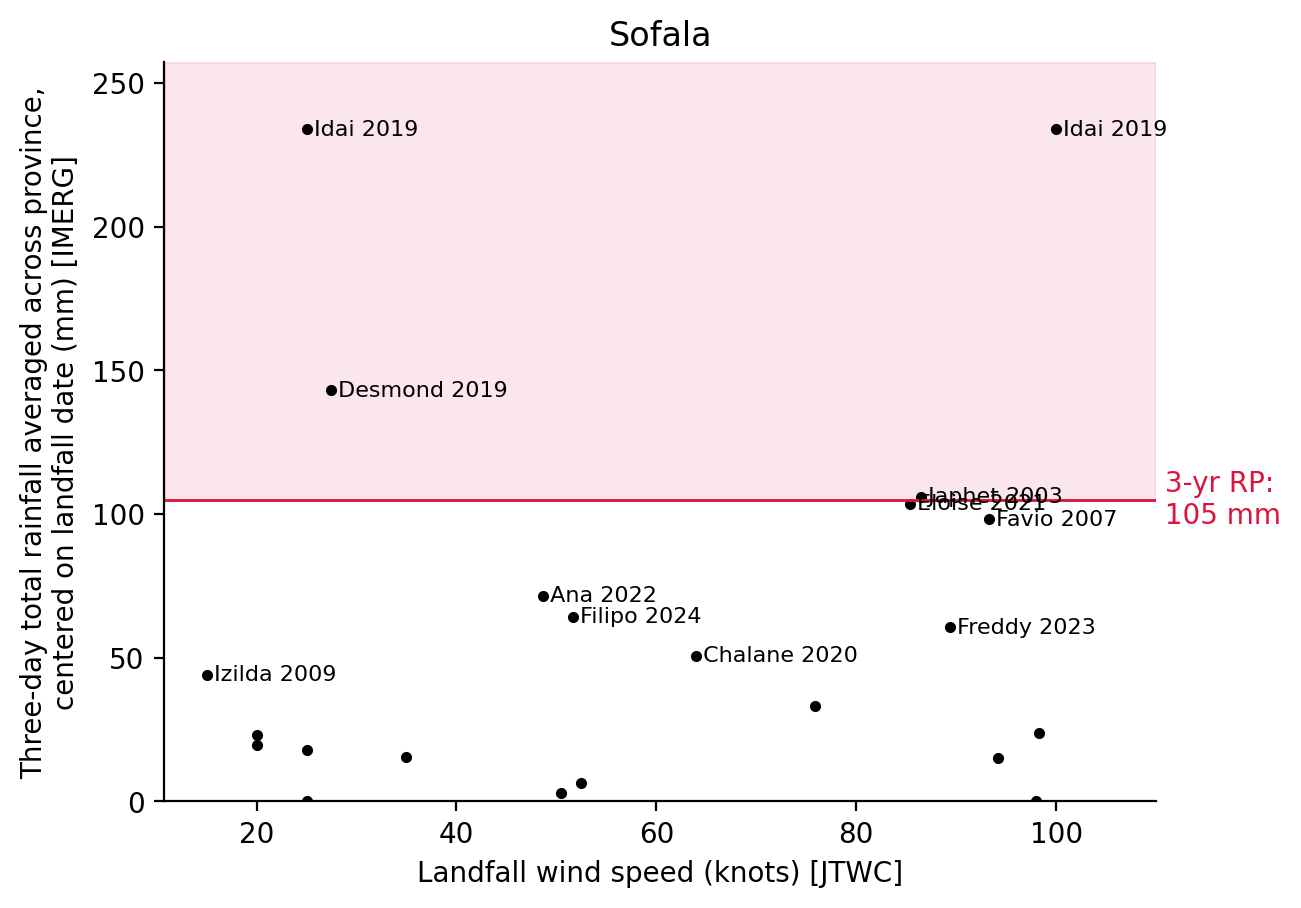

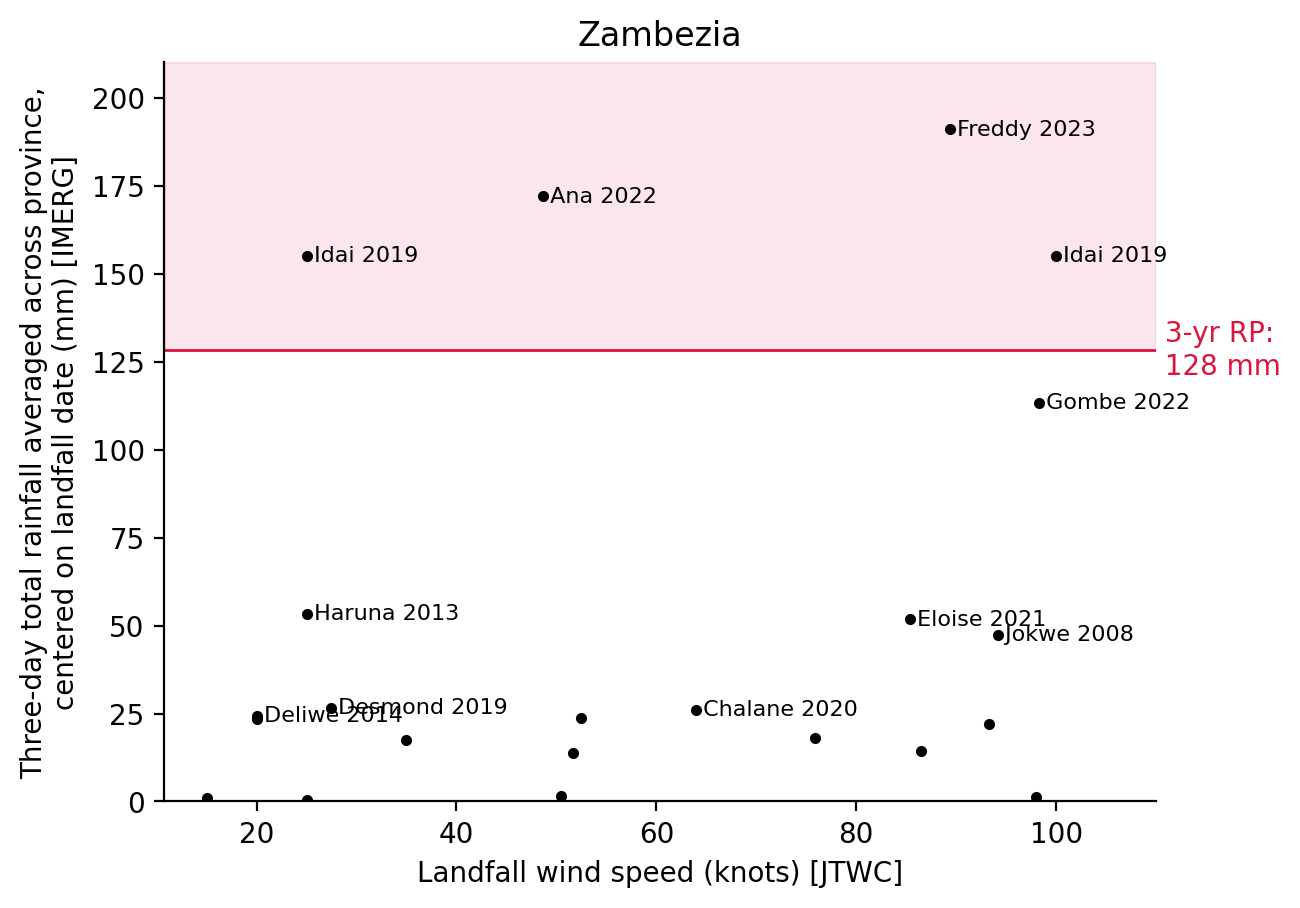

In [16]:
rp = 3
col_name = "sum_mean_rain"
color = "crimson"

for pcode, group in combined_df.groupby("pcode"):
    fig, ax = plt.subplots(dpi=200)

    # calculate RP based only on complete seasons
    dff = group[group["SEASON"] < 2024].copy()
    dff = calculate_rp(dff, col_name, total_seasons)
    dff = dff.sort_values("rp")

    # interpolate return value
    rv = np.interp(rp, dff["rp"], dff[col_name])
    top_edge = dff[col_name].max() * 1.1
    right_edge = dff["USA_WIND"].max() + 10

    group.plot(
        x="USA_WIND",
        y=col_name,
        ax=ax,
        linewidth=0,
        marker=".",
        color="k",
    )
    ax.axhline(rv, linewidth=1, color=color)
    ax.axhspan(rv, top_edge, color=color, alpha=0.1)
    ax.annotate(
        f" 3-yr RP:\n {rv:.0f} mm",
        (right_edge, rv),
        va="center",
        color=color,
    )

    # annotate high rainfall events
    for nameseason, row in group.set_index("nameseason").iterrows():
        if row[col_name] > group[col_name].median():
            ax.annotate(
                f" {nameseason}",
                (row["USA_WIND"], row[col_name]),
                fontsize=8,
                va="center",
            )

    ax.legend().remove()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(right=right_edge)
    ax.set_ylim(bottom=0, top=top_edge)
    ax.set_title(group.iloc[0]["ADM1_PT"])
    ax.set_xlabel("Landfall wind speed (knots) [JTWC]")
    ax.set_ylabel(
        "Three-day total rainfall averaged across province,\ncentered on landfall date (mm) [IMERG]"
    )

In [38]:
## This is where the 120mm originated
sorted_df = (
    combined_df.groupby("nameseason")
    .max()
    .sort_values(by="sum_mean_rain", ascending=False)
    .head(
        math.floor(23 / 3)
    )[  # 23 is the number of seasons and 3 is the target RP
        "sum_mean_rain"
    ]
    .min()
)
sorted_df

np.float64(120.84253799999999)

In [39]:
threshold = 120 # we want to get 7 storms so fine tuning this

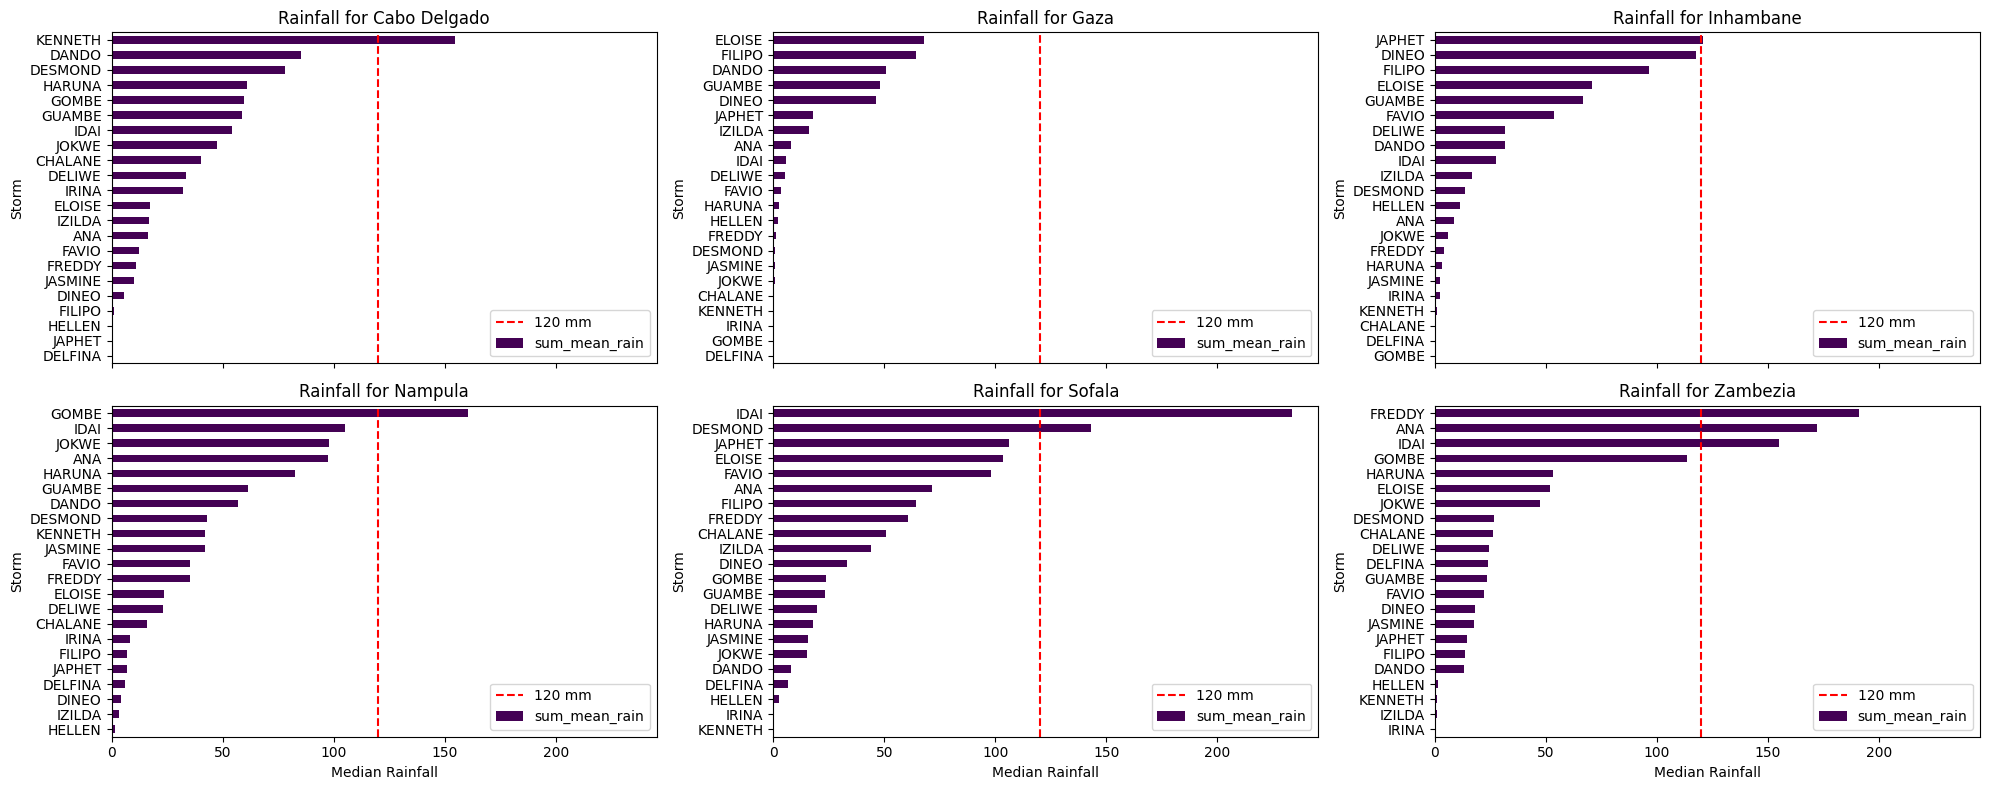

In [40]:
grouped = combined_df.groupby("ADM1_PT")

num_provinces = len(grouped)
ncols = 3
nrows = math.ceil(num_provinces / ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 4 * nrows),
    sharex=True,
)

axes = axes.flatten()

for ax, (province, group) in zip(axes, grouped):
    df_pivot = group.pivot_table(
        index="NAME",
        values="sum_mean_rain",
    )
    df_pivot.fillna(0, inplace=True)

    df_pivot["total_rainfall"] = df_pivot.sum(axis=1)
    df_pivot = df_pivot.sort_values(by="total_rainfall", ascending=False)

    df_pivot.drop(columns="total_rainfall", inplace=True)

    df_pivot.plot(kind="barh", stacked=True, ax=ax, colormap="viridis")

    ax.axvline(
        x=threshold, color="red", linestyle="--", label=f"{threshold} mm"
    )

    ax.set_title(f"Rainfall for {province}")
    ax.set_xlabel("Median Rainfall")
    ax.set_ylabel("Storm")
    ax.legend(loc="lower right")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

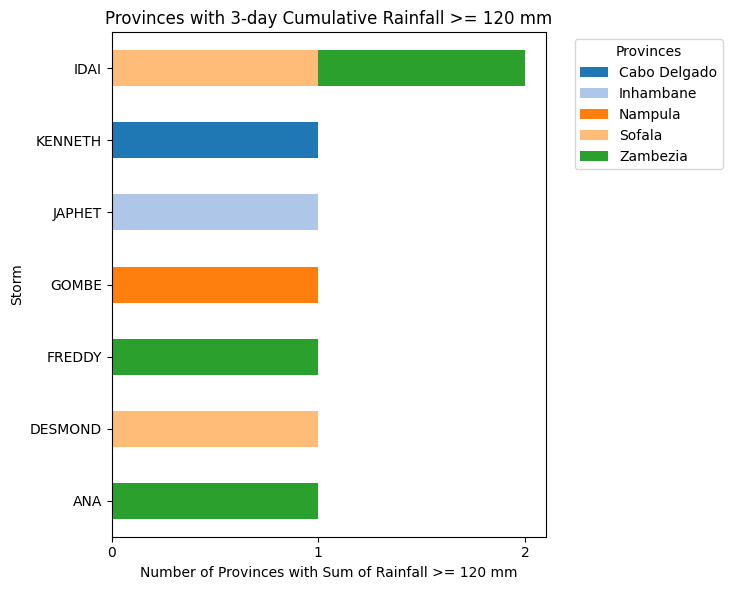

In [41]:
df_above_mm = combined_df[
    combined_df[["NAME", "ADM1_PT", "sum_mean_rain"]]["sum_mean_rain"]
    >= threshold
]

storm_pivot = (
    df_above_mm[["NAME", "ADM1_PT"]]
    .drop_duplicates()
    .groupby(["NAME", "ADM1_PT"])
    .size()
    .unstack(fill_value=0)
)

storm_pivot["total"] = storm_pivot.sum(axis=1)

storm_pivot = storm_pivot.sort_values(by="total", ascending=True).drop(
    columns=["total"]
)

unique_provinces = storm_pivot.columns
colors = cm.tab20.colors[: len(unique_provinces)]
province_color_map = dict(zip(unique_provinces, colors))

# Plot
fig, ax = plt.subplots(figsize=(7.5, 6))

storm_pivot.plot(
    kind="barh",
    stacked=True,
    ax=ax,
    color=[province_color_map[province] for province in unique_provinces],
)

ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax.set_ylabel("Storm")
ax.set_xlabel(f"Number of Provinces with Sum of Rainfall >= {threshold} mm")
ax.set_title(f"Provinces with 3-day Cumulative Rainfall >= {threshold} mm")

ax.legend(
    title="Provinces",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    labels=unique_provinces,
)

# Adjust layout
plt.tight_layout()
plt.show()